<b>Time Series</b>

an ordered sequence of values usually equally spaced over timeevery year, day, second or even every few microseconds like in the audio clip.

- Analyze anything that evolves over time.

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras

In [5]:
def plot_series(time, series, format='-', start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format,label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    plt.figure(figsize=(10, 6))
    plt.show()

Types

- Univariate: a singlie value at each time-step
![Alt text](explanation_images/univariate.png)

- Multivariate: multiple values at each time-step
![Alt text](explanation_images/multivariate.png)


<b>Applications:</b>

- Imputaion 
- Forcasting
- Anomoly Detection

<b>Common Patterns of time series</b>

- Trend: Drift Up or down
![Alt text](explanation_images/trend.png)

In [3]:
# Linear trend
def trend(time, slope=0):
    return slope * time

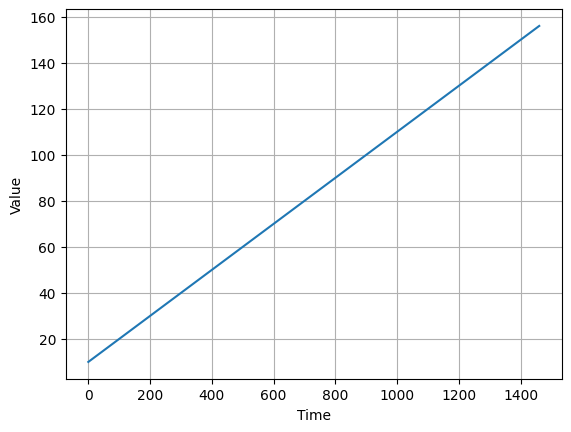

<Figure size 1000x600 with 0 Axes>

In [6]:
time = np.arange(4 * 365 + 1)
basline = 10
series = basline + trend(time, 0.1)

plot_series(time, series)

In [7]:
time

array([   0,    1,    2, ..., 1458, 1459, 1460])

In [8]:
series

array([ 10. ,  10.1,  10.2, ..., 155.8, 155.9, 156. ])

- Seasonality: patterns repeats at predictable seasons
    - peaks
    - troughs

![Alt text](explanation_images/Seasonality.png)


In [15]:
# creates a seasonal pattern
def seasonal_pattern(season_time):
    return np.where(season_time <0.4,
                    np.sin(season_time * 2 * np.pi),
                    1/np.exp(3 * season_time))

In [11]:
# reapets a seasonal pattern
def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

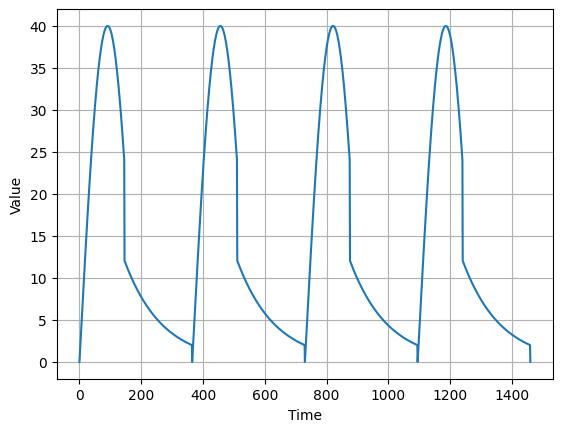

<Figure size 1000x600 with 0 Axes>

In [16]:
amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

plot_series(time, series)

- Trend & Seasonality
![Alt text](explanation_images/trend&seas.png)

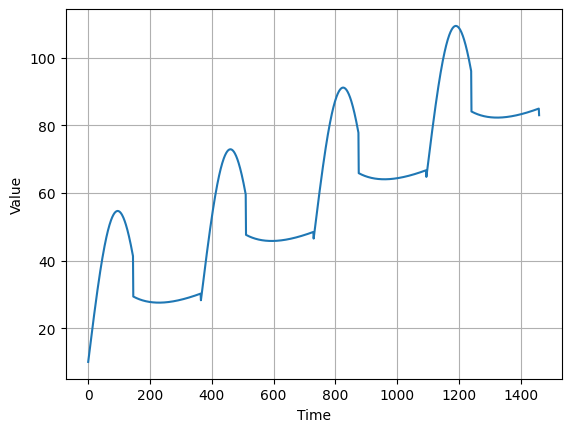

<Figure size 1000x600 with 0 Axes>

In [17]:
slope = 0.05
series = basline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
plot_series(time, series)

- White noise: Completely unpredictable, random numbers
![Alt text](explanation_images/whitenoise.png)

In [18]:
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)#every peice of boise is independant than the other
    return rnd.randn(len(time))* noise_level

But in real life there could be correlation between the noise themselves

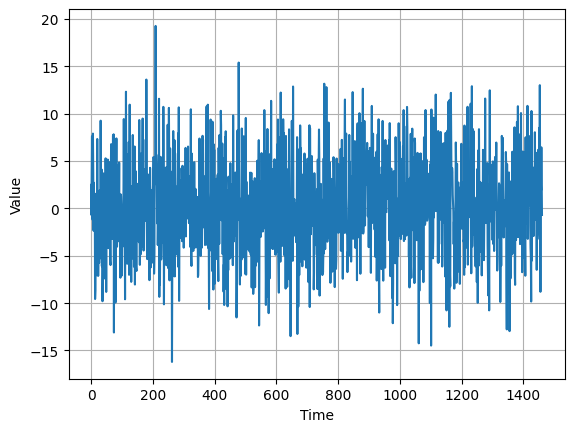

<Figure size 1000x600 with 0 Axes>

In [19]:
noise_level = 5
noise = white_noise(time, noise_level, seed=42)
plot_series(time, noise)

- Trend & Seasonality & Noise: thats realistic

![Alt text](explanation_images/allpatterns.png)


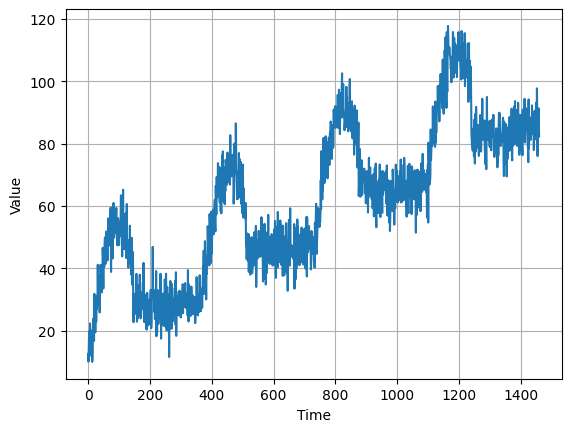

<Figure size 1000x600 with 0 Axes>

In [20]:
series += noise
plot_series(time, series)

<b>Forecasting</b>

<b>To mesure performancce:</b>

1- fixed partitioning

![Alt text](explanation_images/fixedPartitioning.png)


We also train on the test period (which is not usual in ML) because it contains the most recent is the one that is most useful info to predict the future.

2- Roll-forward Partitioning

![Alt text](explanation_images/rollForward.png)

it will require more training time, but it will mimick the 

In [29]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

<b>Naive Forescasting</b>

Take the last value and assume the next will be the same.

![Alt text](explanation_images/naiveForcasting.png)

In [30]:
naive_forecast = series[split_time - 1: -1]

In [31]:
def plot_series_2(time, series, format='-', start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format,label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

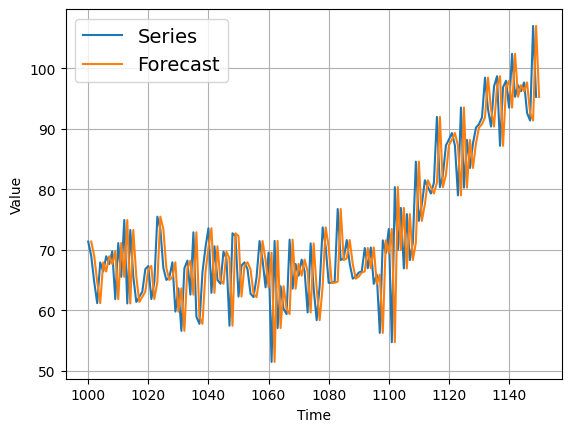

In [33]:
plot_series_2(time_valid, x_valid, start=0, end=150 ,label="Series")
plot_series_2(time_valid, naive_forecast, start=1, end=151,label="Forecast")

The real data is the same as the day before, this is naive forecasting.

To know if it's good or bad
we can calculate the MSE

<b>Metrics</b>

Needed to evaluate the error

- MSE: Errors (diffrence) and we square them
- RMSE: We take the root of the MSE
- MAE: just the mean of the absolute value of the errors
- MAPE: mean absolute percentage error (the ratio between the absolute error and the absolute values )

In [36]:
errors = naive_forecast - x_valid
abs_errors = np.abs(errors)
mae = abs_errors.mean()
mae

5.737599821477467

- To compute the moving average: the mean of the past n values for example 30 days. it eleminates a lot of the noise, but it doesn't elemnate trends or seasonality. So it ends up performing wosre than naive forecasting.

![Alt text](explanation_images/movingAverage.png)




In [38]:
# this one is slow
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

In [39]:
# this one is much faster
def moving_average_forecast_2(series, window_size):
    mov = np.cumsum(series)
    mov[window_size:] = mov[window_size:] - mov[:-window_size]
    return mov[window_size - 1:-1]/ window_size

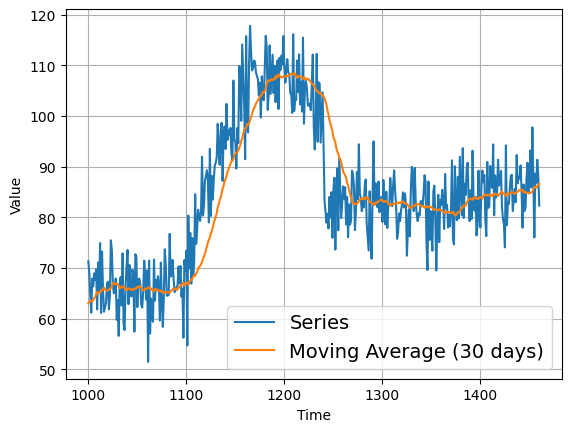

In [41]:
moving_avg = moving_average_forecast_2(series, 30)[split_time-30:]

plot_series_2(time_valid, x_valid, label="Series")
plot_series_2(time_valid, moving_avg, label="Moving Average (30 days)")

- This is much much smoother than the naive forecast

In [43]:
errors = moving_avg - x_valid
abs_errors = np.abs(errors)
mae = abs_errors.mean()
mae

5.228743865052252

- To fix this we remove the trend and seasonality from the time series. It's called Diffrencing (a simple technique)


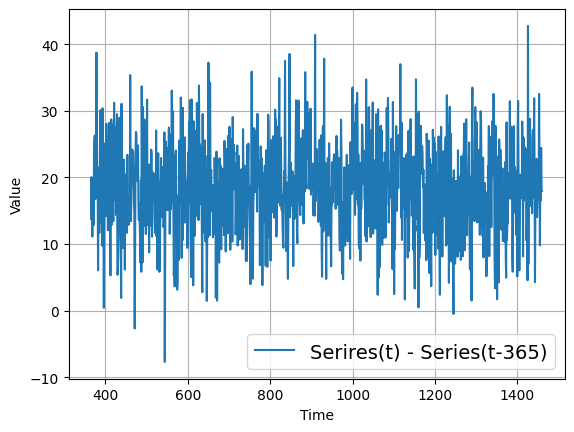

<Figure size 1000x600 with 0 Axes>

In [44]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]
plot_series(diff_time, diff_series, label="Serires(t) - Series(t-365)")

- It look like noise

- After performing the diffrenceing we obtained the time series with no trend and no seasonality. 
- We can then use a moving average to forecast the new time seres, which is for the diffrence not for the orginal so we need to add back the srires.

![Alt text](explanation_images/forecastAfterDiffrence.png)

- We notice a noise, so we use smoothing

![Alt text](explanation_images/centeredWindows.png)

- Time windows
We can convert a time sries to a dataset to use machine learning

In [45]:
# window shift 
# drop remainder = true becuse some ML expect a fixed length so we better drop it
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1])) # transform it so that it return the one last elemnt and the other data
    dataset = dataset.batch(batch_size).prefetch(1) # better use shuffle specially when we use GD which is usually the case
    return dataset

In [46]:
window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

- Linear regression model

In [47]:
model = keras.models.Sequential([
    keras.layers.Dense(1, input_shape=[window_size])
])

- Stochastic GD with some momentum which often converge much faster

In [49]:
optimizer = keras.optimizers.SGD(learning_rate=1e-5,momentum=0.9) 

- Huber good to use when we want to optimize the mean absolute error
- the huber loss converges much better than rmse
- it's quadratic for small errors, but linear for large ones

In [50]:
model.compile(loss=keras.losses.Huber(), 
              optimizer=optimizer,
              metrics=['mae'])

- this will be called at the end of each epoch and it will interrupt traiinng when the model stops improving in the validation period.
- this callback will interrupt training if the passed validation loss remains unchanged for the last 10 consequative epochs.
- Usefull for reducing overfitting

In [51]:
early_stopping = keras.callbacks.EarlyStopping(patience=10)

In [52]:
model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 2s 52ms/step - loss: 17.0512 - mae: 17.5446 - val_loss: 13.2122 - val_mae: 13.7033
Epoch 2/500
31/31 [==============================] - 0s 5ms/step - loss: 11.3666 - mae: 11.8558 - val_loss: 10.3487 - val_mae: 10.8376
Epoch 3/500
31/31 [==============================] - 0s 6ms/step - loss: 10.9001 - mae: 11.3897 - val_loss: 10.3099 - val_mae: 10.8005
Epoch 4/500
31/31 [==============================] - 0s 5ms/step - loss: 10.5787 - mae: 11.0686 - val_loss: 9.8403 - val_mae: 10.3255
Epoch 5/500
31/31 [==============================] - 0s 5ms/step - loss: 10.4233 - mae: 10.9139 - val_loss: 9.5451 - val_mae: 10.0318
Epoch 6/500
31/31 [==============================] - 0s 6ms/step - loss: 10.0828 - mae: 10.5703 - val_loss: 10.0144 - val_mae: 10.5049
Epoch 7/500
31/31 [==============================] - 0s 5ms/step - loss: 9.8613 - mae: 10.3496 - val_loss: 9.3326 - val_mae: 9.8177
Epoch 8/500
31/31 [==============================] - 0s 5ms

- We don't shuffle, we only want to make predictions here

In [53]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    return model.predict(ds)